# Supervised training for RANS flows around airfoils

## Overview 

Let's directly look at an example with a fairly complicated context:
we have a turbulent airflow around wing profiles, and we'd like to know the average motion
and pressure distribution around this airfoil for different Reynolds numbers and angles of attack.
Thus, given an airfoil shape, Reynolds numbers, and angle of attack, we'd like to obtain
a velocity field $\mathbf{u}$ and a pressure field $p$ in a computational domain $\Omega$
around the airfoil in the center of $\Omega$.

This is classically approximated with _Reynolds-Averaged Navier Stokes_ (RANS) models, and this
setting is still one of the most widely used applications of Navier-Stokes solver in industry.
However, instead of relying on traditional numerical methods to solve the RANS equations,
we know aim for training a neural network that completely bypasses the numerical solver,
and produces the solution in terms of $\mathbf{u}$ and $p$.

## Code coming up...

Let's get started with the implementation. Note that we'll skip the data generation process here. This example is adapted from [this codebase](https://github.com/thunil/Deep-Flow-Prediction), which you can check out for details. Here, we'll simply download a small set of training data generated with a Spalart-Almaras RANS simulation in [OpenFOAM](https://openfoam.org/).

In [1]:
import numpy as np
import os.path, random
import torch
from torch.utils.data import Dataset
print("Torch version {}".format(torch.__version__))

if not os.path.isfile('data-airfoils.npz'):
  import urllib.request
  url="https://ge.in.tum.de/download/2019-deepFlowPred/data.npz"
  print("Downloading training data (300MB), this can take a few minutes the first time...")
  urllib.request.urlretrieve(url, 'data-airfoils.npz')

npfile=np.load("data-airfoils.npz")
print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))

print("Size of the inputs array: "+format(npfile["inputs"].shape))


Torch version 1.7.1
Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


Now we have some training data. In general it's very important to understand the data we're working with as much as possible (for any ML task the _garbage-in-gargabe-out_ principle definitely holds). We should at least understand the data in terms of dimensions and rough statistics, but ideally also in terms of content. Otherwise we'll have a very hard time interpreting the results of a training run. And despite all the DL magic: if you can't make out any patterns in your data, NNs surely won't find any useful ones.

Hence, let's look at one of the training samples... The following is just some helper code to show images side by side.


Here are all 3 inputs are shown at the top (mask,in x, in y) 
Side by side with the 3 output channels (p,vx,vy) at the bottom:


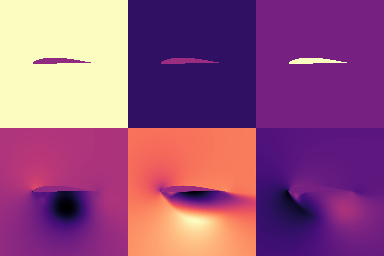

In [31]:
from PIL import Image
from matplotlib import cm

def show(a, stats=False): # helper to show three target channels, normalized with colormap
  for i in range(3):
    b = np.flipud(a[i].transpose())
    min,mean,max = np.min(b),np.mean(b),np.max(b); 
    if stats: print([b[0,0],min,mean,max])
    b -= min; b /= (max-min)
    if stats: print("{}".format(["p:","ux:","uy:"][i])) # note, for inputs the first channel is the mask...
    display(Image.fromarray( cm.magma(b, bytes=True) ))

def showSbs(a1,a2, stats=False): # helper to show three target channels, normalized with colormap side by side
  c=[]
  for i in range(3):
    b = np.flipud( np.concatenate((a2[i],a1[i]),axis=1).transpose())
    min, mean, max = np.min(b), np.mean(b), np.max(b); 
    if stats: print([b[0,0],min,mean,max])
    b -= min; b /= (max-min)
    c.append(b)
  c = np.concatenate(c,axis=1)
  display(Image.fromarray( cm.magma(c, bytes=True) ))

num=72
print("\nHere are all 3 inputs are shown at the top (mask,in x, in y) \nSide by side with the 3 output channels (p,vx,vy) at the bottom:")
showSbs(npfile["inputs"][num],npfile["targets"][num])


Next, let's define a small helper class `DfpDataset` to organize inputs and targets. We'll transfer the corresponding data to the pytorch `DataLoader` class. 

Also set up some globals to control training parameters, maybe most importantly: the learning rate `lr`, i.e. $\eta$ from the previous setions. When your training run doesn't converge this is the first parameter to experiment with.

Here, we'll keep it relatively small throughout. (_Learning rate decay_ would be better, i.e. give slightly faster training, but is omitted here for clarity.) 

In [3]:
# some global training parameters

# number of training epochs
epochs = 100
# batch size
batch_size = 10
# learning rate
lr = 0.00002

class DfpDataset():
    def __init__(self, inputs,targets): 
        self.inputs  = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

tdata = DfpDataset(npfile["inputs"],npfile["targets"])
vdata = DfpDataset(npfile["vinputs"],npfile["vtargets"])

trainLoader = torch.utils.data.DataLoader(tdata, batch_size=batch_size, shuffle=True , drop_last=True) 
valiLoader  = torch.utils.data.DataLoader(vdata, batch_size=batch_size, shuffle=False, drop_last=True) 

print("Training & validation batches: {} , {}".format(len(trainLoader),len(valiLoader) ))

Training & validation batches: 32 , 8


## Network setup

Now we can set up the architecture of our neural network, we'll use a fully convolutional U-net. This is a widely used architecture. It uses the typical stack of convolutions across different spatial resolutions. The main trick is to introduce _skip connection_ from the encoder to the decoder part, to ensure no information is lots during feature extraction. (Note that this only works if the network is to be used as a whole. It doesn't work in situations where we'd, e.g., want to use the decoder as an own unit.)

Here's a overview of the architecure:

![An overview of the U-net we're using for this learning task](resources/supervised-airfoils-unet.jpg)

First, we'll define a helper to set up a convolutional block in the network, `blockUNet`. Note, we don't use any pooling! Instead we use strides and transpose convolutions (these need to be symmetric for the decoder part, i.e. have an uneven kernel size), following [best practices](https://distill.pub/2016/deconv-checkerboard/).

In [13]:
import os, sys, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd 
import torch.utils.data 

def blockUNet(in_c, out_c, name, transposed=False, bn=True, relu=True, size=4, pad=1, dropout=0.):
    block = nn.Sequential()

    if relu:
        block.add_module('%s_relu' % name, nn.ReLU(inplace=True))
    else:
        block.add_module('%s_leakyrelu' % name, nn.LeakyReLU(0.2, inplace=True))

    if not transposed:
        block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True))
    else:
        block.add_module('%s_upsam' % name, nn.Upsample(scale_factor=2))
        # reduce kernel size by one for the upsampling (ie decoder part)
        block.add_module('%s_tconv' % name, nn.Conv2d(in_c, out_c, kernel_size=(size-1), stride=1, padding=pad, bias=True))

    if bn:
        block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    if dropout>0.:
        block.add_module('%s_dropout' % name, nn.Dropout2d( dropout, inplace=True))

    return block
    
class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.):
        super(DfpNet, self).__init__()
        channels = int(2 ** channelExponent + 0.5)

        self.layer1 = nn.Sequential()
        self.layer1.add_module('layer1', nn.Conv2d(3, channels, 4, 2, 1, bias=True))

        self.layer2 = blockUNet(channels  , channels*2, 'layer2', transposed=False, bn=True,  relu=False, dropout=dropout )
        self.layer3 = blockUNet(channels*2, channels*2, 'layer3', transposed=False, bn=True,  relu=False, dropout=dropout )
        self.layer4 = blockUNet(channels*2, channels*4, 'layer4', transposed=False, bn=True,  relu=False, dropout=dropout )
        self.layer5 = blockUNet(channels*4, channels*8, 'layer5', transposed=False, bn=True,  relu=False, dropout=dropout ) 
        self.layer6 = blockUNet(channels*8, channels*8, 'layer6', transposed=False, bn=True,  relu=False, dropout=dropout , size=2,pad=0)
        self.layer7 = blockUNet(channels*8, channels*8, 'layer7', transposed=False, bn=False, relu=False, dropout=dropout , size=2,pad=0)
     
        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer7 = blockUNet(channels*8, channels*8, 'dlayer7', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer6 = blockUNet(channels*16,channels*8, 'dlayer6', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer5 = blockUNet(channels*16,channels*4, 'dlayer5', transposed=True, bn=True, relu=True, dropout=dropout ) 
        self.dlayer4 = blockUNet(channels*8, channels*2, 'dlayer4', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer3 = blockUNet(channels*4, channels*2, 'dlayer3', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer2 = blockUNet(channels*4, channels  , 'dlayer2', transposed=True, bn=True, relu=True, dropout=dropout )

        self.dlayer1 = nn.Sequential()
        self.dlayer1.add_module('dlayer1_relu', nn.ReLU(inplace=True))
        self.dlayer1.add_module('dlayer1_tconv', nn.ConvTranspose2d(channels*2, 3, 4, 2, 1, bias=True))

    def forward(self, x):
        # note, this Unet stack could be automated of course - but it's a bit clearer this way...
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out7 = self.layer7(out6)
        # ... bottleneck ...
        dout6 = self.dlayer7(out7)
        dout6_out6 = torch.cat([dout6, out6], 1)
        dout6 = self.dlayer6(dout6_out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2 = torch.cat([dout3, out2], 1)
        dout2 = self.dlayer2(dout3_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)



Initialize net...

The `expo` parameter here controls the exponent for the feature maps of our Unet: this directly scales the network size (3 gives a model with ca. 150k parameters). This is relatively small for a generative model for $3 \times 128^2 = \text{ca. }49k$ outputs, but yields fast training times and prevents overfitting given the relatively small data set we're using here. Hence it's a good starting point.

In [22]:
# channel exponent to control network size
expo = 3

# setup network
net = DfpNet(channelExponent=expo)
#print(net) # to double check the details...

model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

# crucial parameter to keep in view: how many parameters do we have?
print("Trainable params: {}   -> crucial! always keep in view... ".format(params)) 

net.apply(weights_init)

criterionL1 = nn.L1Loss()
optimizerG = optim.Adam(net.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=0.0)

targets = torch.autograd.Variable(torch.FloatTensor(batch_size, 3, 128, 128))
inputs  = torch.autograd.Variable(torch.FloatTensor(batch_size, 3, 128, 128))


DfpNet(
  (layer1): Sequential(
    (layer1): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (layer2): Sequential(
    (layer2_leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer2_conv): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (layer2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (layer3_leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer3_conv): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (layer3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (layer4_leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer4_conv): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (layer4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer5): Sequential(
    (layer5_leakyrelu): Leaky

## Training

Finally, we can train

In [6]:
history_L1 = []
history_L1val = []

if os.path.isfile("model"):
  print("Found existing model, loading & skipping training")
  net.load_state_dict(torch.load(doLoad)) # optionally, load existing model

else:
  print("Training from scratch")
  for epoch in range(epochs):
      net.train()
      L1_accum = 0.0
      for i, traindata in enumerate(trainLoader, 0):
          inputs_curr, targets_curr = traindata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          net.zero_grad()
          gen_out = net(inputs)

          lossL1 = criterionL1(gen_out, targets)
          lossL1.backward()
          optimizerG.step()
          L1_accum += lossL1.item()

      # validation
      net.eval()
      L1val_accum = 0.0
      for i, validata in enumerate(valiLoader, 0):
          inputs_curr, targets_curr = validata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          outputs = net(inputs)
          outputs_curr = outputs.data.cpu().numpy()

          lossL1val = criterionL1(outputs, targets)
          L1val_accum += lossL1val.item()

      # data for graph plotting
      history_L1.append( L1_accum / len(trainLoader) )
      history_L1val.append( L1val_accum / len(valiLoader) )

      if i<3 or i%20==0:
          print( "Epoch: {}, L1 train: {:7.5f}, L1 vali: {:7.5f}".format(epoch, history_L1[-1], history_L1val[-1]) )

  torch.save(net.state_dict(), "model" )
  print("Training done, saved model")


Training from scratch
Epoch: 0, L1 train: 0.23608, L1 vali: 0.22773
Epoch: 1, L1 train: 0.22596, L1 vali: 0.22119
Epoch: 2, L1 train: 0.21803, L1 vali: 0.21487
Epoch: 3, L1 train: 0.21162, L1 vali: 0.20664
Epoch: 4, L1 train: 0.20456, L1 vali: 0.20017
Epoch: 5, L1 train: 0.19872, L1 vali: 0.19361
Epoch: 6, L1 train: 0.19307, L1 vali: 0.18902
Epoch: 7, L1 train: 0.18764, L1 vali: 0.18313
Epoch: 8, L1 train: 0.18274, L1 vali: 0.17782
Epoch: 9, L1 train: 0.17719, L1 vali: 0.17278
Epoch: 10, L1 train: 0.17280, L1 vali: 0.16770
Epoch: 11, L1 train: 0.16881, L1 vali: 0.16246
Epoch: 12, L1 train: 0.16275, L1 vali: 0.15712
Epoch: 13, L1 train: 0.15851, L1 vali: 0.15384
Epoch: 14, L1 train: 0.15592, L1 vali: 0.14751
Epoch: 15, L1 train: 0.14877, L1 vali: 0.14329
Epoch: 16, L1 train: 0.14498, L1 vali: 0.13888
Epoch: 17, L1 train: 0.13987, L1 vali: 0.13402
Epoch: 18, L1 train: 0.13579, L1 vali: 0.13007
Epoch: 19, L1 train: 0.13181, L1 vali: 0.12809
Epoch: 20, L1 train: 0.12681, L1 vali: 0.12327
E

Yay, the model is trained...! 

The losses nicely went down in terms of absolute values, let's look at the graphs.

This is typically important to identify longer-term trends in the data. In practice it's tricky to spot whether the overall trend of 100 or so noisy numbers is going slightly up or down.

[(100,)]


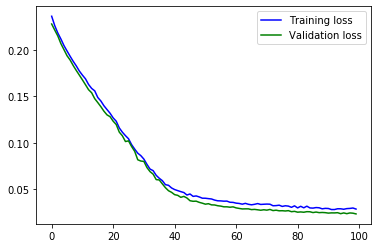

In [28]:
import matplotlib.pyplot as plt

l1train = np.asarray(history_L1)
l1vali  = np.asarray(history_L1val)

plt.plot(np.arange(l1train.shape[0]),l1train,'b',label='Training loss')
plt.plot(np.arange(l1vali.shape[0] ),l1vali ,'g',label='Validation loss')
plt.legend()
plt.show()


You should see a curve that goes down for ca. 40 epochs, and then starts to flatten out. In the last part, it's still slowly decreasing, and most importantly, the validation loss is not **increasing**. This would be a certain sign of overfitting, and something that we should avoid. (Try decreasing the amount of training data artificially, then you should be able to intentionally cause overfitting.)

If you look closely at this graph, you should spot something peculiar:
_Why is the validation loss **lower** than the training loss_?
The data is similar to the training data of course, but in a way it's slightly "tougher", because the model certainly never received any validation samples during training. So how can the L1 loss be _lower_ for these inputs?

This is a subtlety of the training loop above: it runs a training step first, and the loss for each point in the graph is measured with the evolving state of the network in an epoch. The network is updated, and afterwards runs through the validation samples. Thus all validation samples are using a state that is definitely different (and hopefully a bit better) than the initial states of the epoch. Hence, the validation loss can be slightly lower.

A general word of caution here: never evaluate your model with training data! That won't tell you much because overfitting is a very common problem. At least use validation data, and if that looks good, try some more different inputs, i.e., _test data_. (That's coming up next below.) 

First, let's visualize some validation samples. All visualizations in the following show 2 rows: the target at the top, the model output at the bottom. Each row shows pressure, x velocity, and y velocity (from left to right). Typically, especially the _pressure_ in the first column is interesting, due to it's cubic scaling w.r.t. the varying velocities, it is the toughest quantity to infer for the network.

Validation sample 0, target (top) & model output (bottom)


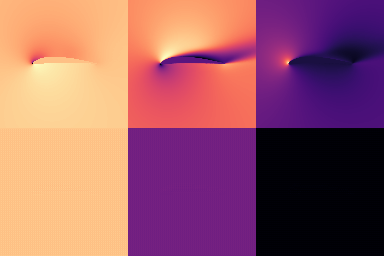

Validation sample 10, target (top) & model output (bottom)


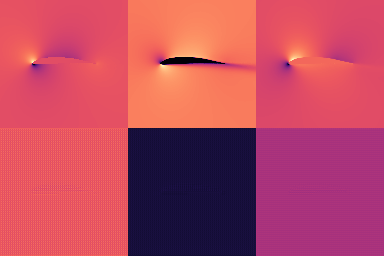

Validation sample 20, target (top) & model output (bottom)


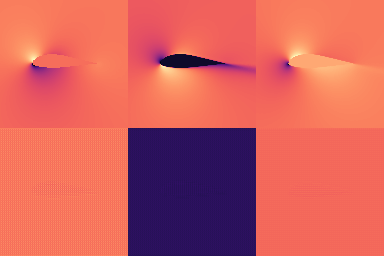

In [19]:
net.eval()
for i, validata in enumerate(valiLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())
    
    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()
    if i<3: # only show first 3 of each batch here, enlarge to show all
        print("Validation sample {}, target (top) & model output (bottom)".format(i * batch_size) ) # only show each first one
        showSbs(targets_curr[0] , outputs_curr[0])


## Test evaluation

Now let's look at **proper** test samples, i.e. OOD samples, for which in this case we'll use new airfoil shapes. These are shapes that the network never saw in any training samples, and hence it tells us a bit about how well the model generalizes to new shapes.

As these samples are at least slightly OOD, we can draw conclusions about how well the model generalizes, which the validation data would not really tell us.

Loaded 10/10 test samples
Test sample 0, loss 0.16995319724082947, target (top) & model output (bottom)


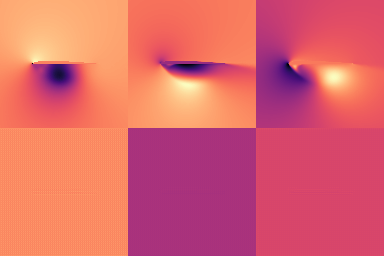

Test sample 1, loss 0.1963399201631546, target (top) & model output (bottom)


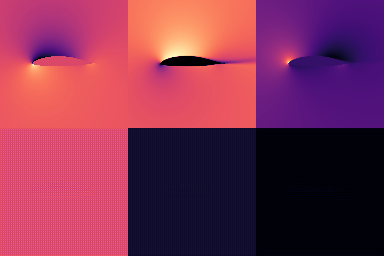

Test sample 2, loss 0.18705692887306213, target (top) & model output (bottom)


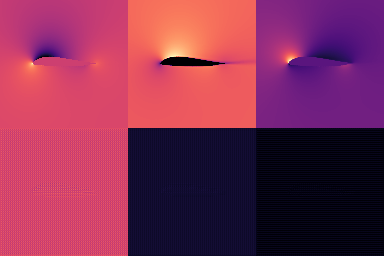

Test sample 3, loss 0.15921331942081451, target (top) & model output (bottom)
Test sample 4, loss 0.17740412056446075, target (top) & model output (bottom)
Test sample 5, loss 0.20241335034370422, target (top) & model output (bottom)
Test sample 6, loss 0.16636453568935394, target (top) & model output (bottom)
Test sample 7, loss 0.21479596197605133, target (top) & model output (bottom)
Test sample 8, loss 0.16884702444076538, target (top) & model output (bottom)
Test sample 9, loss 0.17588728666305542, target (top) & model output (bottom)

Average test error: 0.1818275645375252


In [21]:
if not os.path.isfile('data-airfoils-test.npz'):
  import urllib.request
  url="https://ge.in.tum.de/download/2019-deepFlowPred/data_test.npz"
  print("Downloading test data, this should be fast...")
  urllib.request.urlretrieve(url, 'data-airfoils-test.npz')

nptfile=np.load('data-airfoils-test.npz')
print("Loaded {}/{} test samples".format(len(nptfile["test_inputs"]),len(nptfile["test_targets"])))

testdata = DfpDataset(nptfile["test_inputs"],nptfile["test_targets"])
testLoader  = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=False, drop_last=True) 

net.eval()
L1t_accum = 0.
for i, validata in enumerate(testLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())

    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()

    lossL1t = criterionL1(outputs, targets)
    L1t_accum += lossL1t.item()

    print("Test sample {}, loss {}, target (top) & model output (bottom)".format(i, lossL1t.item()) ) 
    if i<3: # again only show first 3 of each batch here, enlarge value to show all
        showSbs(targets_curr[0] , outputs_curr[0])

print("\nAverage test error: {}".format( L1t_accum/len(testLoader) ))

The average test error with the default settings should be ca. 0.03. This is not too bad for new shapes, but clearly leaves room for improvement! There are many obvious things to try here (see the suggestions below), e.g. longer training, larger data sets, larger networks etc. 

---

## Nex steps

* Experiment with learning rate, dropout, and model size to reduce the error on the test set. How low can you get it with the given training data?

* As you'll see, it's a bit limited here what you can get out of this dataset, head over to [the main github repo of this project](https://github.com/thunil/Deep-Flow-Prediction) to download larger data sets, or generate own data

**TODO us: provide data with "errors" (nan & huge neg number in 1 cell), filter out to make model train...**
